In [ ]:
###################################################################
# Feature Importance + 모델 개선 핵심 요약
#
# 1) Permutation Importance로 전체 피처 영향도 분석
#    → 핵심 TOP5:
#       ['tenure', 'numTechTickets', 'Contract_Two year',
#        'MonthlyCharges', 'InternetService_Fiber optic']
#
# 2) 중요도 낮은 피처를 "1개씩 제거"하며 F1 / Recall 변화 체크
#    → 대부분 성능 변화 없음
#    → 단, 'tenure'·'numTechTickets' 제거 시 성능 크게↓ (중요 피처 확정)
#
# 3) TOP5만 사용해 Decision Tree 하이퍼파라미터 튜닝
#    → 최종 성능: F1 = 0.7397 / Recall = 0.81 / Accuracy = 0.85
#
# 결론:
#    - 중요 피처 5개만 사용해도 가장 높은 성능 확보
###################################################################


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. 데이터 불러오기
file_path = "../data/processed/Customer_Churn_Dataset_0_impute_onehot.csv"
df = pd.read_csv(file_path)

# 2. 불필요한 컬럼 제거 (인덱스 컬럼 등)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 3. 문제지(X)와 정답지(y) 나누기
target = [col for col in df.columns if col.startswith("Churn")][0]
X = df.drop(columns=[target])
y = df[target]

# 4. 데이터 분할 (Train: 75%, Test: 25%)
# stratify=y 옵션은 이탈 고객의 비율을 유지하며 나누기 위해 필수입니다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

# 잘 나뉘었는지 크기 확인
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (5282, 32)
X_test: (1761, 32)


In [3]:
from sklearn.metrics import classification_report
import pandas as pd

# 중요도 낮은 피처 목록 (원하는 대로 수정 가능)
feature_list = list(fi.sort_values(ascending=True).index)
results = []

for feat in feature_list:
    # 1개만 뺀 버전으로 학습 (feat 하나만 drop)
    X_train_sub = X_train.drop(columns=[feat])
    X_test_sub  = X_test.drop(columns=[feat])

    model = DecisionTreeClassifier(max_depth=5,
                                   class_weight='balanced',
                                   random_state=42)
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)

    # 클래스 1의 f1-score / recall만 꺼내기
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_1 = report["1"]["f1-score"]
    recall_1 = report["1"]["recall"]

    results.append({
        "제거_피처": feat,
        "f1_클래스1": f1_1,
        "recall_클래스1": recall_1
    })

df_results = pd.DataFrame(results)
df_results


NameError: name 'fi' is not defined

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 기본 설정
feature_names = X.columns.tolist()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_importances = []   # 각 fold별 중요도 저장

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"=== Fold {fold} ===")
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 2. 사장님이 쓰시던 DT 설정 그대로 사용
    model = DecisionTreeClassifier(
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_tr, y_tr)

    # 3. Permutation Importance 계산 (F1 기준, 클래스 1)
    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10,
        random_state=42,
        scoring="f1"   # 이탈(1) 기준 F1
    )

    # 이번 fold의 중요도 평균값 저장
    all_importances.append(result.importances_mean)

# 4. fold별 결과를 평균/표준편차로 정리
all_importances = np.array(all_importances)  # (n_folds, n_features)

mean_importances = all_importances.mean(axis=0)
std_importances = all_importances.std(axis=0)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "mean_importance": mean_importances,
    "std_importance": std_importances
}).sort_values("mean_importance", ascending=False)

perm_df


=== Fold 1 ===
=== Fold 2 ===
=== Fold 3 ===
=== Fold 4 ===
=== Fold 5 ===


,feature,mean_importance,std_importance
1,tenure,0.193464,0.012198
5,numTechTickets,0.166010,0.008543
27,Contract_Two year,0.070012,0.005749
2,MonthlyCharges,0.054856,0.013349
13,InternetService_Fiber optic,0.033702,0.019641
25,StreamingMovies_No internet service,0.009405,0.018809
19,DeviceProtection_No internet service,0.008505,0.017010
3,TotalCharges,0.007225,0.003692
21,TechSupport_No internet service,0.000757,0.001513
17,OnlineBackup_No internet service,0.000412,0.000824


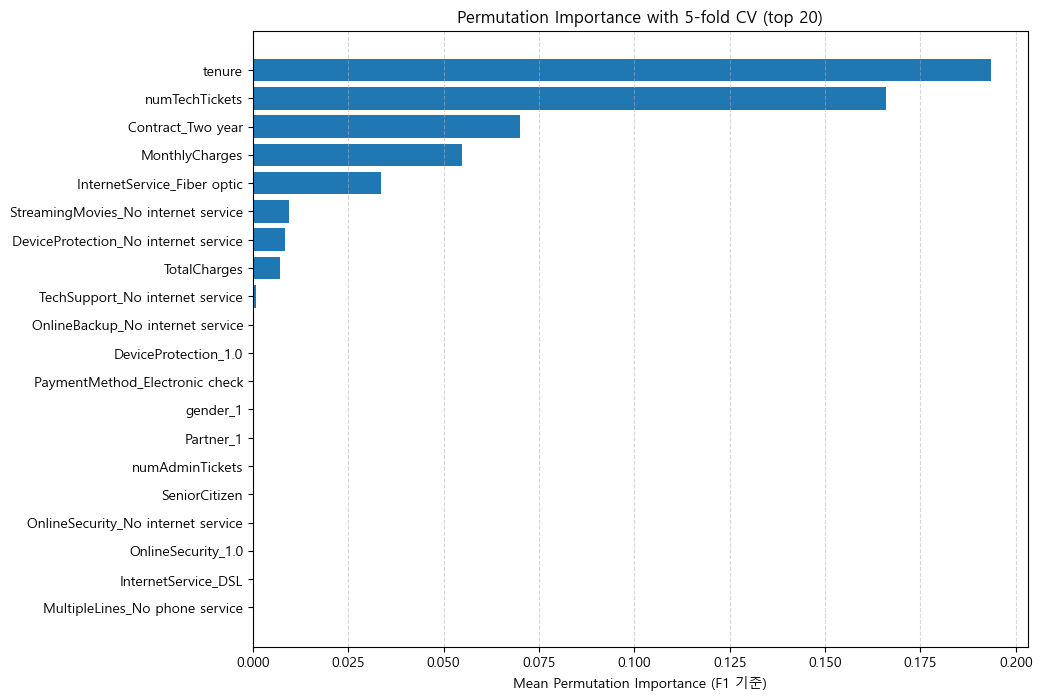

In [ ]:
# 상위 N개만 보여주고 싶으면 top_n 조절 (예: 20)
top_n = 20
plot_df = perm_df.head(top_n).iloc[::-1]  # 위에서 N개 가져와서 아래→위 순으로 뒤집기

plt.figure(figsize=(10, 8))
plt.barh(plot_df["feature"], plot_df["mean_importance"])
plt.xlabel("Mean Permutation Importance (F1 기준)")
plt.title(f"Permutation Importance with 5-fold CV (top {top_n})")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 모델 생성
tree = DecisionTreeClassifier(max_depth=5,class_weight='balanced')

# 학습
tree.fit(X_train, y_train)

# 추론
pred_train_tree = tree.predict(X_train)
pred_test_tree = tree.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
print("DecsionTree 정밀도(Precision) - 1기준")
print(f"Trainset : {precision_score(y_train, pred_train_tree)}, Testset: {precision_score(y_test, pred_test_tree)}")


DecsionTree 정밀도(Precision) - 1기준
Trainset : 0.6420643729189789, Testset: 0.6464646464646465


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_tree))

---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3880
           1       0.64      0.83      0.72      1402

    accuracy                           0.83      5282
   macro avg       0.79      0.83      0.80      5282
weighted avg       0.85      0.83      0.84      5282



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_tree))

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1294
           1       0.65      0.82      0.72       467

    accuracy                           0.83      1761
   macro avg       0.79      0.83      0.80      1761
weighted avg       0.85      0.83      0.84      1761



In [ ]:
tree.feature_importances_

array([1.07545455e-17, 3.06844871e-01, 4.46366568e-02, 1.94282449e-02,
       0.00000000e+00, 2.48980465e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.56615961e-02, 0.00000000e+00, 0.00000000e+00,
       2.74512490e-16, 0.00000000e+00, 1.51010631e-03, 4.67777915e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.04140354e-02, 2.77846245e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
fi = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
fi

tenure                                   3.068449e-01
Contract_Two year                        2.778462e-01
numTechTickets                           2.489805e-01
InternetService_Fiber optic              6.566160e-02
MonthlyCharges                           4.463666e-02
Contract_One year                        3.041404e-02
TotalCharges                             1.942824e-02
DeviceProtection_No internet service     4.677779e-03
DeviceProtection_1.0                     1.510106e-03
OnlineBackup_1.0                         2.745125e-16
SeniorCitizen                            1.075455e-17
MultipleLines_1.0                        0.000000e+00
Partner_1                                0.000000e+00
Dependents_1                             0.000000e+00
gender_1                                 0.000000e+00
numAdminTickets                          0.000000e+00
OnlineSecurity_No internet service       0.000000e+00
OnlineSecurity_1.0                       0.000000e+00
InternetService_DSL         

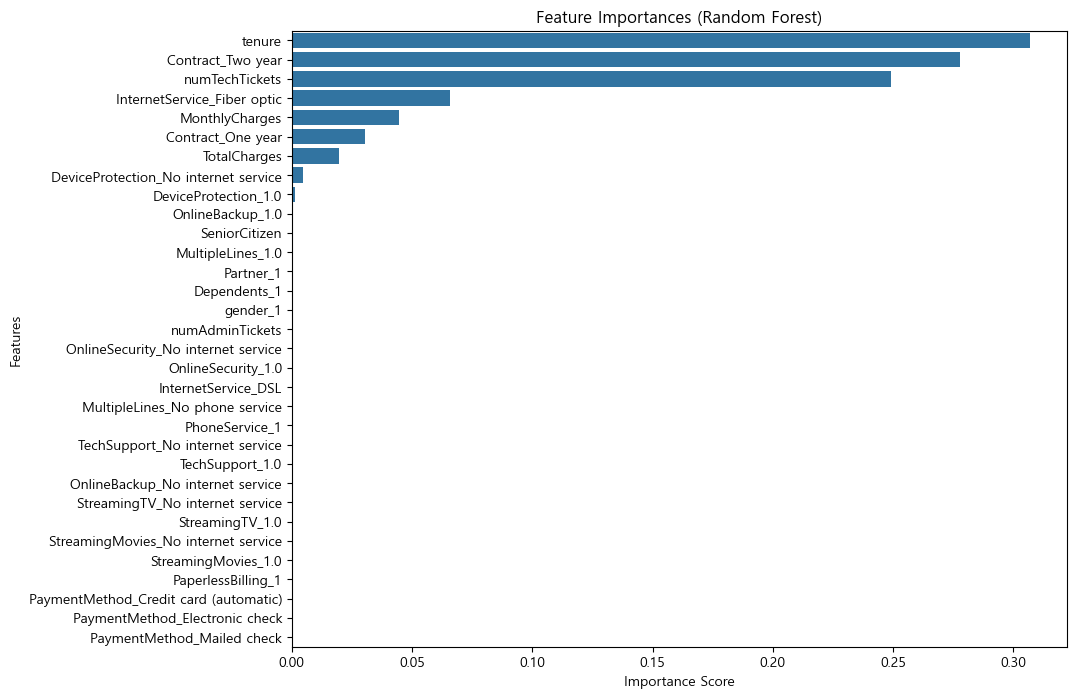

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 중요도와 변수명을 묶어서 데이터프레임 만들기
# (rf_model 대신 사용하신 모델 변수명을 넣으세요. 예: rf, tree 등)
importances = tree.feature_importances_
feature_names = X_train.columns

# 보기 좋게 정렬하기 위해 Series로 변환
ft_series = pd.Series(importances, index=feature_names)
ft_series = ft_series.sort_values(ascending=False)  # 내림차순 정렬

# 2. 시각화 그리기
plt.figure(figsize=(10, 8))  # 그림 사이즈 조절 (가로, 세로)
plt.title("Feature Importances (Random Forest)")

# seaborn을 이용해 가로 막대 그래프 그리기
sns.barplot(x=ft_series, y=ft_series.index)

# 라벨 달기
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# 🔥 인코딩된 컬럼 이름으로 TOP5 지정
top5 = [
    "tenure",
    "numTechTickets",
    "Contract_Two year",
    "MonthlyCharges",
    "InternetService_Fiber optic"
]

# 이 5개만 사용하는 X 만들기
X_train_top5 = X_train[top5]
X_test_top5  = X_test[top5]

params = {
    "max_depth": [3, 5, 6, 7, 8, 10, 12, 15, None],
    "min_samples_split": [2, 4, 6, 8, 10, 12, 15, 20, 30],
    "min_samples_leaf": [1, 2, 3, 4, 6, 8, 10],
    "criterion": ["gini", "entropy"],
    "class_weight": [
        None,
        "balanced",
        {0:1, 1:1.5},
        {0:1, 1:2},
        {0:1, 1:2.5},
        {0:1, 1:3},
        {0:1, 1:4},
    ],
}

best_f1 = -1
best_model = None
best_setting = None

for depth in params["max_depth"]:
    for split in params["min_samples_split"]:
        for leaf in params["min_samples_leaf"]:
            for cri in params["criterion"]:
                for cw in params["class_weight"]:
                    model = DecisionTreeClassifier(
                        max_depth=depth,
                        min_samples_split=split,
                        min_samples_leaf=leaf,
                        criterion=cri,
                        class_weight=cw,
                        random_state=42,
                    )
                    model.fit(X_train_top5, y_train)
                    pred = model.predict(X_test_top5)
                    f1 = f1_score(y_test, pred)

                    if f1 > best_f1:
                        best_f1 = f1
                        best_model = model
                        best_setting = {
                            "max_depth": depth,
                            "min_samples_split": split,
                            "min_samples_leaf": leaf,
                            "criterion": cri,
                            "class_weight": cw,
                        }

print("=== 최적 모델 설정 ===")
print(best_setting)
print(f"최고 F1-score: {best_f1:.4f}")

print("\n=== 최적 모델 Detailed Report ===")
print(classification_report(y_test, best_model.predict(X_test_top5)))


=== 최적 모델 설정 ===
{'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': {0: 1, 1: 1.5}}
최고 F1-score: 0.7397

=== 최적 모델 Detailed Report ===
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1294
           1       0.68      0.81      0.74       467

    accuracy                           0.85      1761
   macro avg       0.80      0.84      0.82      1761
weighted avg       0.86      0.85      0.85      1761



In [9]:
import os
import joblib

# 1) TOP5 feature 리스트
top5 = [
    "tenure",
    "numTechTickets",
    "Contract_Two year",
    "MonthlyCharges",
    "InternetService_Fiber optic",
]

# 2) 사용한 학습/평가용 데이터 (이미 있다면 생략 가능)
X_train_top5 = X_train[top5]
X_test_top5  = X_test[top5]

# 위에서 찾은 최적 모델(best_model)이 잘 들어있는지 확인
print("=== 최적 모델 설정 ===")
print(best_setting)
print(f"최고 F1-score: {best_f1:.4f}")

# 3) 모델 패키지 구성
model_package = {
    "model": best_model,              # 최적 DecisionTreeClassifier
    "features": top5,                 # 사용한 컬럼 이름 5개
    "model_type": "DecisionTree",     # 정보용 메타데이터
    "params": best_setting,           # 최적 하이퍼파라미터
    "data_source": "../data/processed/Customer_Churn_Dataset_0_impute_onehot.csv",
}

# 4) 저장 경로 생성 (없으면 폴더 자동 생성)
save_dir = "../src/models/ML/model_dir"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "DecisionTree_model.pkl")

# 5) 실제 저장
joblib.dump(model_package, save_path)

print("\n 모델 저장 완료:", save_path)

=== 최적 모델 설정 ===
{'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': {0: 1, 1: 1.5}}
최고 F1-score: 0.7397

 모델 저장 완료: ../src/models/ML/model_dir\DecisionTree_model.pkl


In [10]:
import joblib

model_package = joblib.load("../src/models/ML/model_dir/DecisionTree_model.pkl")

for k, v in model_package.items():
    print(f"{k}: {type(v)}")
    print(v)
    print("----")


model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
DecisionTreeClassifier(class_weight={0: 1, 1: 1.5}, max_depth=7,
                       min_samples_split=15, random_state=42)
----
features: <class 'list'>
['tenure', 'numTechTickets', 'Contract_Two year', 'MonthlyCharges', 'InternetService_Fiber optic']
----
model_type: <class 'str'>
DecisionTree
----
params: <class 'dict'>
{'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': {0: 1, 1: 1.5}}
----
data_source: <class 'str'>
../data/processed/Customer_Churn_Dataset_0_impute_onehot.csv
----
